In [80]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

#Avoid future warnings: 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [81]:
df = pd.read_csv('Train_data.csv')

In [82]:
df.drop('cus_CustomerType',axis=1,inplace=True)

In [83]:
# Check both the datatypes and if there is missing values
print(f"Data types:\n{11 * '-'}")
print(f"{df.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df.isnull().sum()}")
df.head()

Data types:
-----------
cus_Gender                    object
cus_MartialTypeId              int64
cus_Dependants               float64
cus_CurrenResTypeId            int64
cus_CurrenStyYear            float64
cus_Age                      float64
IndustryType                   int64
CustomerProfile                int64
CustomerSegment                int64
MarketType                     int64
MarketNoofYearsinBusiness    float64
app_CustProductCatTypeId       int64
app_CustTenure               float64
app_CustInstalCount          float64
app_CustChasAsset            float64
app_CustChasInitial          float64
app_CustChasFinance          float64
app_CustFinanInterest        float64
app_CustEMI                  float64
app_CustGrossLoan            float64
app_CustViaIncomEstIncPm     float64
app_CustViaExpTotExpense     float64
app_CustViaGrossSurplus      float64
app_CustUVAge                float64
app_CustBrandTypeId            int64
app_CustBankClosBal          float64
Label         

,cus_Gender,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,cus_Age,IndustryType,CustomerProfile,CustomerSegment,MarketType,...,app_CustFinanInterest,app_CustEMI,app_CustGrossLoan,app_CustViaIncomEstIncPm,app_CustViaExpTotExpense,app_CustViaGrossSurplus,app_CustUVAge,app_CustBrandTypeId,app_CustBankClosBal,Label
0,M,2750,7.0,2755,22.0,46.0,1783,2693,2695,2729,...,7.0,16765.82,787993.60,59400.0,9505.0,49895.0,0.0,746,16765.82,Pay
1,M,2750,3.0,2755,50.0,29.0,604,2693,2695,2729,...,12.5,6305.85,214399.23,21000.0,3570.0,17430.0,0.0,746,6305.85,Pay
2,M,2750,4.0,2755,20.0,25.0,1783,2693,2695,2729,...,7.3,16180.84,760499.62,77000.0,26900.0,50100.0,0.0,564,16180.84,Pay
3,M,2750,4.0,2755,30.0,33.0,1783,2693,2695,2729,...,7.0,7610.29,312021.90,66000.0,27700.0,38300.0,0.0,564,7610.29,Pay
4,M,2750,4.0,2755,15.0,25.0,1783,2693,2695,2729,...,7.2,15281.16,718214.56,66000.0,24100.0,41900.0,0.0,564,15281.16,Pay


In [84]:
#Converting the text label into integers:
def cate(val):
    """
    This function is used to converting string classes into integer values.
    """
    if val == 'Pay':
        return 0
    else:
        return 1

#Applying a function cate:
df['Label'] = df['Label'].apply(cate)

Positive examples = 389
Negative examples = 453
Proportion of positive to negative examples = 85.87%


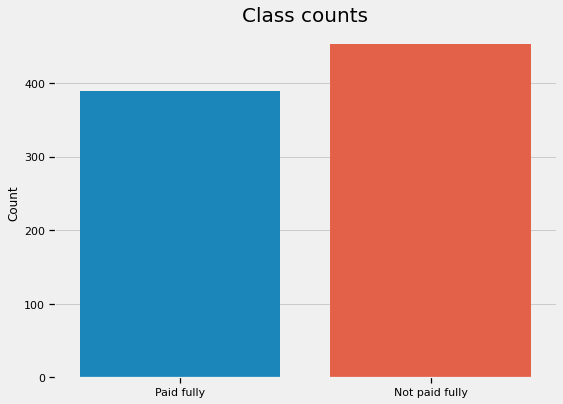

In [85]:
# Get number of positve and negative examples
neg = df[df["Label"] == 1].shape[0]
pos = df[df["Label"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df.Label)
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});
plt.savefig('data_scv.jpg', bbox_inches='tight')

In [86]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["cus_Gender"])
df.head()

,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,cus_Age,IndustryType,CustomerProfile,CustomerSegment,MarketType,MarketNoofYearsinBusiness,...,app_CustGrossLoan,app_CustViaIncomEstIncPm,app_CustViaExpTotExpense,app_CustViaGrossSurplus,app_CustUVAge,app_CustBrandTypeId,app_CustBankClosBal,Label,cus_Gender_F,cus_Gender_M
0,2750,7.0,2755,22.0,46.0,1783,2693,2695,2729,6.0,...,787993.60,59400.0,9505.0,49895.0,0.0,746,16765.82,0,0,1
1,2750,3.0,2755,50.0,29.0,604,2693,2695,2729,5.0,...,214399.23,21000.0,3570.0,17430.0,0.0,746,6305.85,0,0,1
2,2750,4.0,2755,20.0,25.0,1783,2693,2695,2729,10.0,...,760499.62,77000.0,26900.0,50100.0,0.0,564,16180.84,0,0,1
3,2750,4.0,2755,30.0,33.0,1783,2693,2695,2729,NaN,...,312021.90,66000.0,27700.0,38300.0,0.0,564,7610.29,0,0,1
4,2750,4.0,2755,15.0,25.0,1783,2693,2695,2729,6.0,...,718214.56,66000.0,24100.0,41900.0,0.0,564,15281.16,0,0,1


In [87]:
# Original Data
X = df.loc[:, df.columns != "Label"].values
y = df.loc[:, df.columns == "Label"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((673, 27), (169, 27))


In [88]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="median"),rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Original model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="median"),RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Under-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="median"),RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="median"),resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"EasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="median"),SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.906
Under-sampled model's average AUC: 0.905
Over-sampled model's average AUC: 0.905
EasyEnsemble model's average AUC: 0.902
SMOTE model's average AUC: 0.904


In [89]:
# Impute the missing data using features means
imp = Imputer(strategy="median")
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)


# Implement RandomOverSampler
sampler = RandomOverSampler()
X_res, y_res = sampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((724, 27), (724,))

In [90]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [91]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100,scoring='roc_auc' ,cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
grid.fit(X_res, y_res)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.6min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [92]:
print("Area Under Curve on Cross Validation Data:%.2f" % (grid.best_score_*100))
p = grid.best_params_
print(p)

Area Under Curve on Cross Validation Data:92.78
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [93]:
# Evaluate a model with optimized parameters:
rf = RandomForestClassifier(random_state = 42)
best_rf = grid.best_estimator_
best_rf.fit(X_res,y_res)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

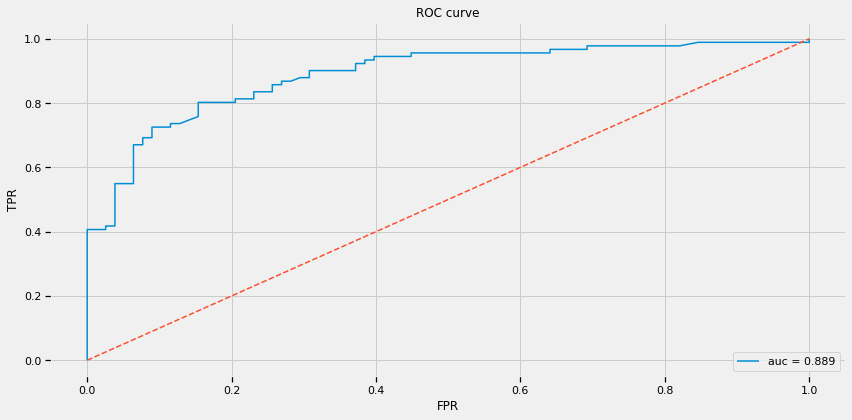

In [94]:
probs = best_rf.predict_proba(X_test)[:, 1:]
auc_score = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"auc = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.tight_layout()
plt.savefig('auc_scv.jpg', bbox_inches='tight')

In [95]:
from collections import Counter 
Counter(y_test)

Counter({1: 91, 0: 78})

<Figure size 1152x576 with 0 Axes>

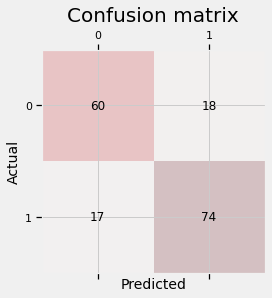

In [96]:
probs = best_rf.predict_proba(X_test)
preds = best_rf.predict(X_test)
conf_mat = confusion_matrix(y_test, preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})
plt.savefig('cm_scv.jpg', bbox_inches='tight')

In [97]:
#Generating sample status:
sample_weight = np.random.RandomState(42).rand(y.shape[0])
sw_train,sw_test = train_test_split(sample_weight,test_size=0.2)

In [103]:
#Caluculating Probability of 1 for a test data:
clf_isotonic = CalibratedClassifierCV(best_rf,cv=10,method='isotonic')
clf_isotonic.fit(X_train,y_train,sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:,-1]

In [104]:
#Making results:
for i in prob_pos_isotonic.argsort():
    print("Predicted_Value:{} Actual_Value:{} Probablity of Pay:{}".format(best_rf.predict(X_test[i].reshape(1,27)),y_test[i],(1-(clf_isotonic.predict_proba(X_test[i].reshape(1,27))[:,-1]))))

Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:1 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97547638]
Predicted_

Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.08276139]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.08228163]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.07787792]
Predicted_Value:[1] Actual_Value:0 Probablity of Pay:[0.07282262]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.07240768]
Predicted_Value:[1] Actual_Value:0 Probablity of Pay:[0.07000438]
Predicted_Value:[1] Actual_Value:0 Probablity of Pay:[0.06919079]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.04601511]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.03737959]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.0333412]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.0333412]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.03199302]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.03091324]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.03091324]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.03077904]
Predicted_Va

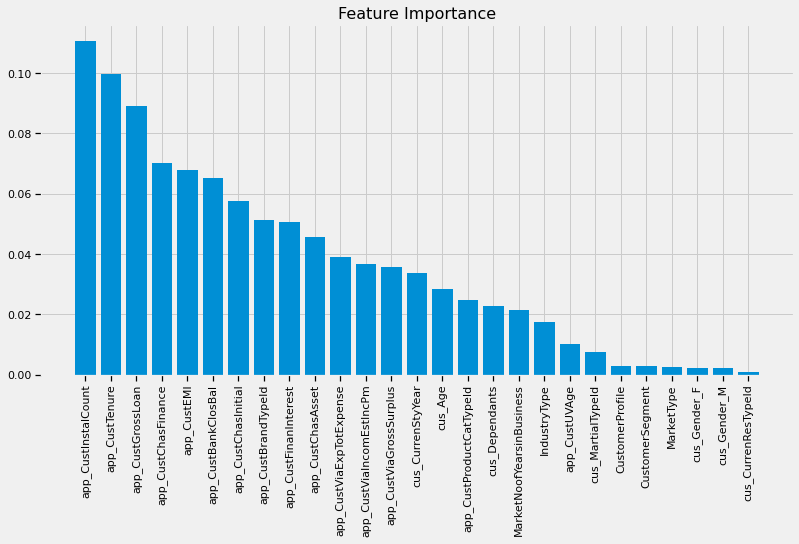

In [105]:
# Plot features importance
importances = best_rf.feature_importances_
indices = np.argsort(best_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 28), importances[indices], align="center")
plt.xticks(range(1, 28), df.columns[df.columns != "Label"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16})
plt.savefig('fi_scv.jpg', bbox_inches='tight')

In [106]:
# Saving model to disk
pickle.dump(clf_isotonic, open('model_ok_iso.pkl','wb'))

In [107]:
len(best_rf.estimators_)

400